In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.datasets import make_blobs, make_moons, make_classification

In [4]:
class LinearClassifier:
    def __init__(self,
                 loss: str = 'log', 
                 alpha: float = 0.01, 
                 max_iter: int = 500, 
                 eps: float = 1e-8,
                ):
        if loss not in ('log', 'hinge', 'perceptron'):
            print('Invalid Loss')
            raise NotImplementedError
            
        loss_fn_dict = {
            'log': self._sigmoid,
            'hinge': self._maximum,
            'perceptron': self._indicator,
        }
            
        self.alpha = alpha
        self.loss_fn = loss_fn_dict[loss]
        self.max_iter = max_iter
        self.w = None
        self.eps = eps
        self.losses = []
        
    
    def fit(self, X, y, lr=0.1, batch_size=None):
        if np.sign(y).all() != 1:
            y = 2*y - 1
        
        m, n = X.shape
        n += 1  # for bias
        
        if batch_size is None:
            batch_size = m
            
        x = np.hstack([np.ones((m, 1)), X])
        self.w = np.random.randn(n)
        
        for i in range(self.max_iter):
            inds = np.random.choice(np.arange(m), size=batch_size)
            self.w = self.w + lr * (
                self.loss_fn(-y[inds] * (x[inds] @ self.w)) * y[inds] @ x[inds] - self.alpha * self.w
            ) / batch_size
            
            loss = self._logloss(y, x)
            self.losses.append(loss)
            
#         for i in range(self.max_iter):
#             iter_loss = 0
#             for item in range(m):
#                 self.w = self.w + lr * self.loss_fn(-y[item] * (x[item, :] @ self.w)) * x[item, :] * y[item] / m
#                 iter_loss += self._logloss(y[item], x[item, :])
#             self.losses.append(iter_loss)

#             if i > 15 and abs(self.losses[-1] - self.losses[-2]) < self.eps:
#                 print('iter stoped on', i)
#                 break
            
    
    def _logloss(self, y, x):
        loss = np.clip(-y * (x @ self.w), 1e-8, 1-1e-8).mean()
        return np.log(1 + np.exp(loss))
    
    
    def predict_proba(self, X):
        m, n = X.shape
        n += 1  # for bias
        x = np.hstack([np.ones((m, 1)), X])
        
        return self._sigmoid(x @ self.w)
    
    
    def predict(self, X):
        probas = self.predict_proba(X)
        
        return probas.round()
            
    
    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    
    def _indicator(self, x):
        return (x > 0).astype(int)
    
    
    def _maximum(self, x):
        return np.max(np.hstack([np.zeros((len(x), 1)), x.reshape(-1,1)]), axis=1)

In [5]:
def plot_mesh_grid(clf, datasets):
    
    i = 1
    plt.figure(figsize=(18,7))
    for ds in datasets:
        plt.subplot(1, len(datasets), i)
    
        eps = 0.3
        
        clf.fit(ds[0], ds[1])

        xx, yy = np.meshgrid(np.linspace(np.min(ds[0][:,0]) - eps, np.max(ds[0][:,0]) + eps, 200),
                             np.linspace(np.min(ds[0][:,1]) - eps, np.max(ds[0][:,1]) + eps, 200))
        
        try:
            z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()][:, :])[:, 1].reshape(xx.shape)
        except:
            z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()][:, :]).reshape(xx.shape)

        plt.pcolormesh(xx, yy, z, cmap='RdYlBu', shading='auto')
        plt.scatter(ds[0][:, 0], ds[0][:, 1], c=ds[1], cmap='Set1', edgecolors='black')
        
        plt.title(f'Accuracy: {accuracy_score(ds[1], clf.predict(ds[0])).round(2)}')
        
        i+=1

# Test Datasets

In [6]:
datasets = (
        make_moons(300, noise=0.2, random_state=42),
        make_blobs(n_samples=300, centers=[[-2,0.5],[2,-0.5]], cluster_std=1, random_state=42),
        make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0)
    )

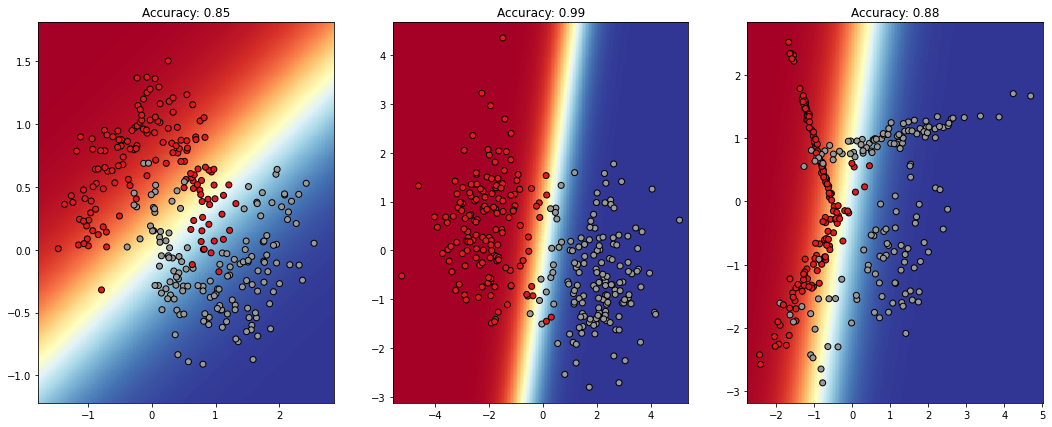

In [7]:
plot_mesh_grid(LinearClassifier(), datasets)

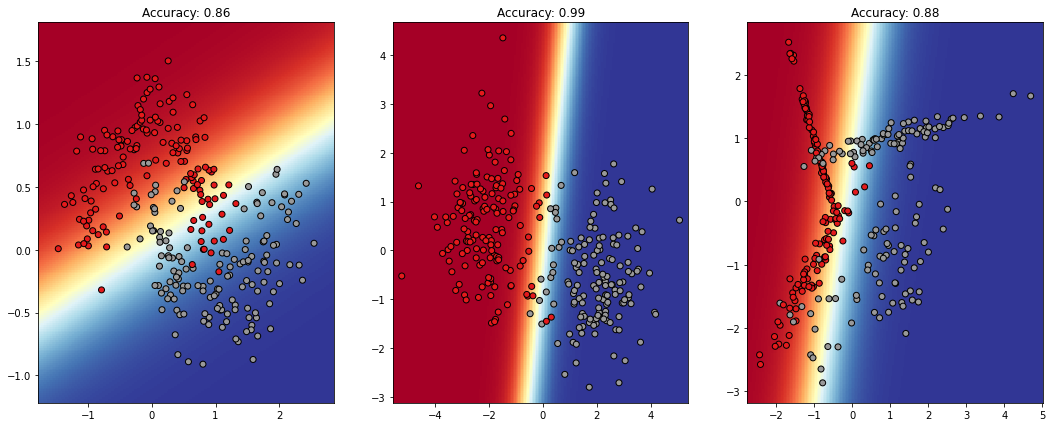

In [8]:
plot_mesh_grid(LogisticRegression(), datasets)

# Breast Cancer

In [9]:
x = load_breast_cancer().data
y = load_breast_cancer().target

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [10]:
logit = LinearClassifier(loss='hinge', max_iter=500)
logit.fit(x, y)

In [11]:
accuracy_score(logit.predict(x), y)

0.9630931458699473

In [12]:
logit.w

array([ 0.05040149, -0.93196791,  0.58929985, -0.15015597, -0.61697058,
        1.41190122, -0.19318391, -1.19856183, -1.08627339,  0.88119721,
       -0.75265916, -0.2216581 ,  0.25660618, -1.26374861, -1.88686931,
       -0.35211642,  1.42586765, -0.46745033, -0.05965603, -0.35988514,
        1.00408279,  0.0643937 , -1.50467778,  0.63196522,  0.58765569,
       -0.93978269, -1.11986448,  0.3645575 , -0.37835032, -0.55614635,
        0.27382872])

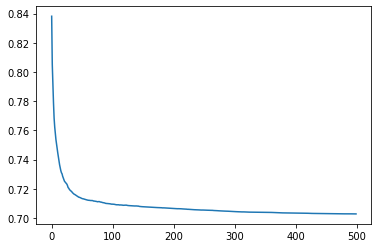

In [13]:
plt.plot(logit.losses)